# MGL870 - TP2 - Utilisation de l’apprentissage machine pour la détection des anomalies
## Pierre Joseph, Jonathan Mésidor, Mohamed Fehd Soufi
## Automne 2024


## Requirements

`pip install jupyter logparser3 drain3`

## Import required libraries

In [ ]:
import os
import pandas as pd
import sys
sys.path.append('../../')
from logparser.Drain import LogParser
import re


Preparation des donnees -utilisation de Drain3 pour parser

In [1]:
import os
from logparser.Drain import LogParser

input_dir = "./BGL/"
output_dir = "./result"
log_file = "BGL_2k.log"

# Make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the log format and regular expressions
log_format = "<Label> <PId> <Date> <Node> <Timestamp> <NodeRepeat> <Type> <Component> <Level> <Content>"
regex = [
    r"(0x)[0-9a-fA-F]+",  # hexadecimal
    r"\d+\.\d+\.\d+\.\d+",  # IP addresses
    r"\d+"  # general digits
]

# Similarity threshold and depth
st = 0.5  # Similarity threshold
depth = 4  # Depth of all leaf nodes

# Create and execute the parser
try:
    parser = LogParser(log_format, indir=input_dir, outdir=output_dir, depth=depth, st=st, rex=regex)
    parser.parse(log_file)
    print("Parsing completed successfully.")
except Exception as e:
    print(f"An error occurred during parsing: {e}")


Parsing file: ./BGL/BGL_2k.log
Total lines:  2000
Processed 50.0% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.869851]
Parsing completed successfully.


## on fait un parsing 

In [4]:
import re
import pandas as pd
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
from tqdm import tqdm
import numpy as np

# Configuration and setup for TemplateMiner
config = TemplateMinerConfig()
drain_parser = TemplateMiner(config=config)

# Define log pattern to match log fields
log_pattern = re.compile(
    r"(?P<Label>\S+)\s"               # Match the Label (e.g., "-")
    r"(?P<PId>\S+)\s"                 # Match the Process ID (e.g., "1117838570")
    r"(?P<Date>\d{4}\.\d{2}\.\d{2})\s"  # Match the Date (e.g., "2005.06.03")
    r"(?P<Node>\S+)\s"                # Match the Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Timestamp>\S+)\s"           # Match the Timestamp (e.g., "2005-06-03-15.42.50.675872")
    r"(?P<NodeRepeat>\S+)\s"          # Match the repeated Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Type>\S+)\s"                # Match the Type (e.g., "RAS")
    r"(?P<Component>\S+)\s"           # Match the Component (e.g., "KERNEL")
    r"(?P<Level>\S+)\s"               # Match the Level (e.g., "INFO")
    r"(?P<Content>.+)"                # Match the Content (e.g., "instruction cache parity error corrected")
)

with open('BGL/BGL_2k.log', 'r') as log_file:
    for line in log_file:
        # Remove any leading/trailing whitespace from the line
        line = line.strip()
        match = log_pattern.match(line)
        if match:
            log_content = match.group("Content")  # Extract the Content field
            result = drain_parser.add_log_message(log_content)
            #Fehd: On ne met pas le template maintenant, parce qu'à chaque ligne, il génère un arbre. Il faut faire dans deux boucles séparées, comme en bas.

log_data = []

# Process the log file with a progress bar
with open('BGL/BGL_2k.log', 'r') as log_file:
    previous_timestamp = None  # Initialize the previous timestamp for calculating DeltaT
    for line in tqdm(log_file, desc="Processing log file"):
        line = line.strip()  # Remove leading/trailing whitespace
        match = log_pattern.match(line)
        if match:
            # Extract matched fields
            log_content = match.group("Content")
            timestamp_str = match.group("Timestamp")
            label = 1 if match.group("Label") == '-' else 0  # Replace '-' with 1, others with 0
            
            # Convert Timestamp to Unix format
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%d-%H.%M.%S.%f').value // 10**9
            
            # Calculate DeltaT (difference in seconds from the previous log)
            deltaT = timestamp - previous_timestamp if previous_timestamp is not None else 0
            previous_timestamp = timestamp  # Update previous timestamp
            
            # Use Drain3 to match the log entry content
            result = drain_parser.match(log_content)

            # Create a dictionary with the parsed data
            log_entry = {
                "Timestamp": timestamp,
                "Content": log_content,
                "Matched Template": result.get_template() if result else "No Template",
                "Cluster ID": result.cluster_id if result else "No Cluster",
                "Label": label,
                "DeltaT": deltaT
            }
            
            # Append the dictionary to the list
            log_data.append(log_entry)

# Convert log data to DataFrame and save to CSV
df = pd.DataFrame(log_data)

# Save the parsed log data to a structured CSV
output_path = 'result/parsed_bgl_2k.log_structured.csv'
df.to_csv(output_path, index=False)

print(f"Parsed log data saved to '{output_path}'")


Processing log file: 2000it [00:00, 3059.48it/s]

Parsed log data saved to 'result/parsed_bgl_2k.log_structured.csv'


Slinding Window

In [ ]:
import pandas as pd
import numpy as np

def sliding_window(structured_log_path, para):
    """
    Split logs into sliding windows/session and aggregate by log keys with labels.
    
    :param structured_log_path: Path to the structured log file (CSV).
    :param para: Parameters for sliding window {"window_size": seconds, "step_size": seconds}.
    :return: DataFrame with columns=[Timestamp, 1, 2, ..., n, Anomaly] where numbers represent log keys and their counts.
    """
    # Read the structured log file
    df_structured = pd.read_csv(structured_log_path)  # Assumes columns: Timestamp, Content, Matched Template, Cluster ID, Label, DeltaT
    
    # Convert Timestamp to datetime format for easier handling
    df_structured['Timestamp'] = pd.to_datetime(df_structured['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')
    
    # Parameters
    window_size = para["window_size"]  # Window size in seconds
    step_size = para["step_size"]      # Step size in seconds
    
    # Initialize results
    result = []
    start_time = df_structured['Timestamp'].min()
    end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    while start_time <= df_structured['Timestamp'].max():
        # Filter logs within the current window
        window_logs = df_structured[(df_structured['Timestamp'] >= start_time) & (df_structured['Timestamp'] < end_time)]
        
        if not window_logs.empty:
            # Count log keys (Cluster ID)
            log_key_counts = window_logs['Cluster ID'].value_counts().to_dict()
            
            # Aggregate anomaly labels (1 if any anomaly exists in the window, else 0)
            anomaly_label = int(window_logs['Label'].max())
            
            # Create a row with timestamp, log key counts, and anomaly label
            row = {
                'Timestamp': start_time,
                **{str(key): log_key_counts.get(key, 0) for key in range(1, len(df_structured['Cluster ID'].unique()) + 1)},
                'Anomaly': anomaly_label
            }
            result.append(row)
        
        # Slide the window
        start_time += pd.to_timedelta(step_size, unit='s')
        end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    # Convert result to DataFrame and fill missing log keys with 0
    result_df = pd.DataFrame(result).fillna(0)
    return result_df

# Parameters for sliding window (5-minute window with 30-second step)
window_size = 5 * 60  # 5 minutes in seconds
step_size = 30  # 30 seconds in seconds

# Generate sliding window dataset
deeplog_df = sliding_window(
    "result/parsed_bgl_2k.log_structured.csv",
    para={'window_size': window_size, 'step_size': step_size}
)

# Save the result to CSV
deeplog_df.to_csv("result/parsed_bgl_2k_sliding_window.csv", index=False)

print("Sliding window results saved to 'result/parsed_bgl_2k_sliding_window.csv'")

Sliding window results saved to 'result/parsed_bgl_2k_sliding_window.csv'


statistiques

Total logs: 2000
Total failures: 1857
Failure percentage: 92.85%

Failures by Cluster ID:
Cluster ID
5      721
69     208
55     121
2      109
3       92
      ... 
73       1
58       1
34       1
62       1
105      1
Name: count, Length: 92, dtype: int64


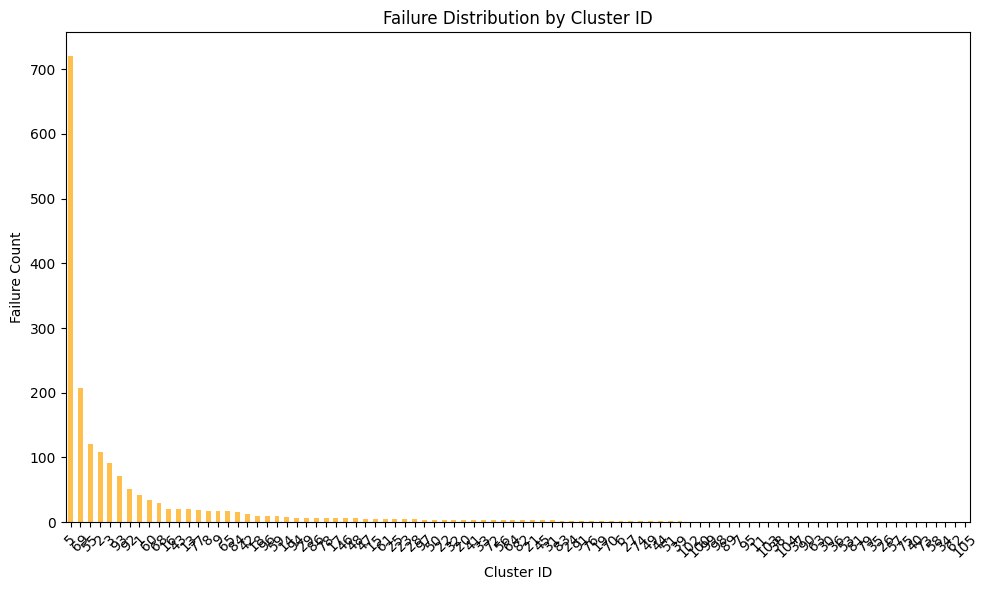


Failures over time:
Date
2005-06-03     8
2005-06-04     1
2005-06-05    45
2005-06-06    15
2005-06-07    16
              ..
2005-12-21     1
2005-12-25     1
2005-12-26     8
2005-12-27     1
2006-01-03     1
Length: 161, dtype: int64


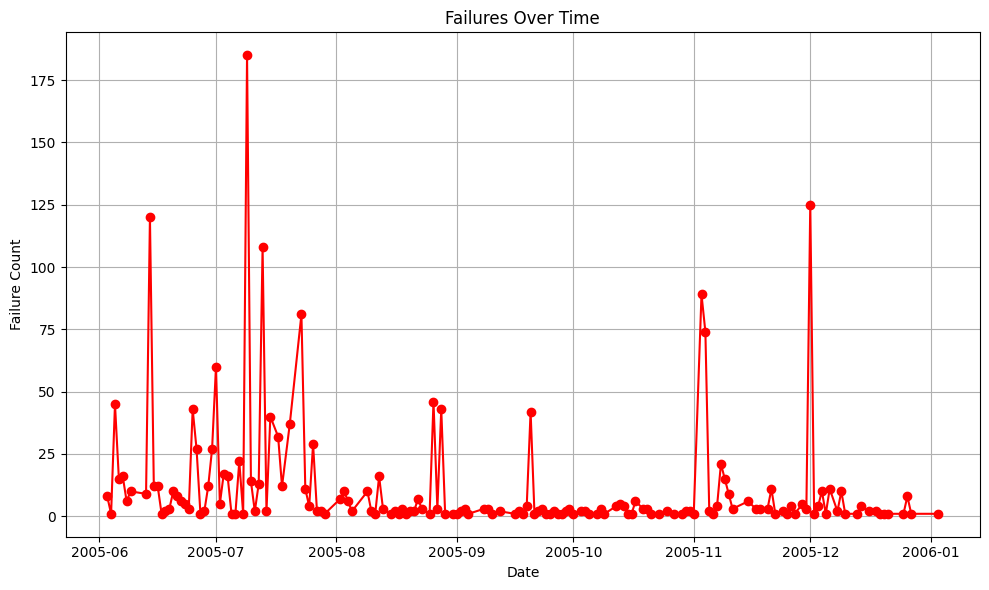


Statistics of time between failures (seconds):
count      1856.000000
mean       9945.591838
std       37290.653139
min           0.030768
25%          18.426893
50%          55.829857
75%         551.373906
max      625690.416573
Name: Timestamp, dtype: float64


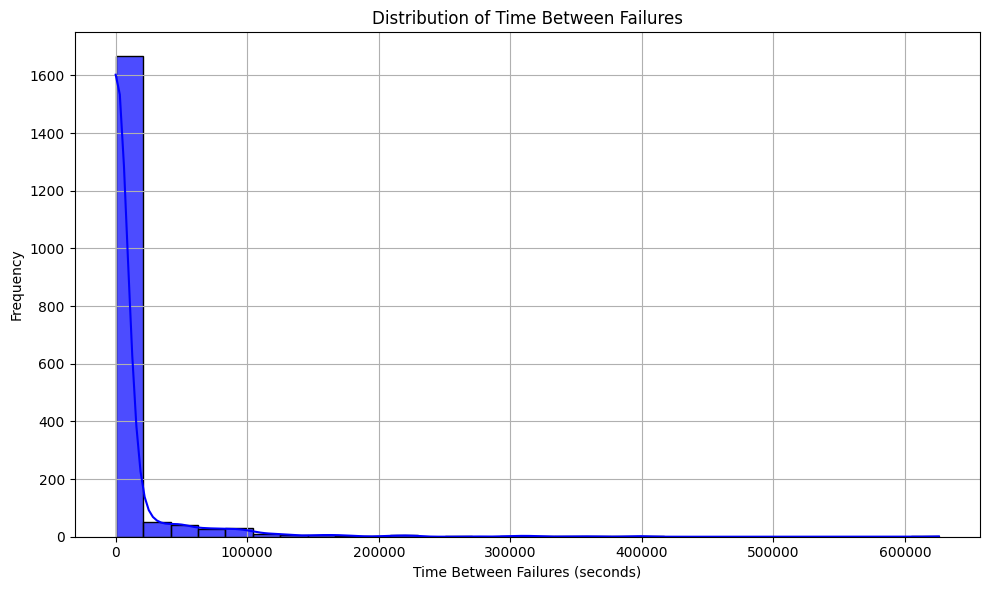

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the structured log data
log_data_path = "result/parsed_bgl_2k.log_structured.csv"  # Path to your structured log data
df = pd.read_csv(log_data_path)

# Convert Timestamp to datetime for easier handling
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Replace Label with numeric values (1 for Anomaly, 0 for Normal)
df['Label'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)

# Total logs and failures
total_logs = len(df)
total_failures = df['Label'].sum()
failure_percentage = (total_failures / total_logs) * 100

print(f"Total logs: {total_logs}")
print(f"Total failures: {total_failures}")
print(f"Failure percentage: {failure_percentage:.2f}%")

# Failure distribution by Cluster ID (log key)
failure_by_cluster = df[df['Label'] == 1]['Cluster ID'].value_counts()
print("\nFailures by Cluster ID:")
print(failure_by_cluster)

# Plot: Failure distribution by Cluster ID
plt.figure(figsize=(10, 6))
failure_by_cluster.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Failure Distribution by Cluster ID')
plt.xlabel('Cluster ID')
plt.ylabel('Failure Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Failure distribution over time
df['Date'] = df['Timestamp'].dt.date
failures_over_time = df[df['Label'] == 1].groupby('Date').size()

print("\nFailures over time:")
print(failures_over_time)

# Plot: Failures over time
plt.figure(figsize=(10, 6))
failures_over_time.plot(kind='line', marker='o', color='red')
plt.title('Failures Over Time')
plt.xlabel('Date')
plt.ylabel('Failure Count')
plt.grid()
plt.tight_layout()
plt.show()

# Duration between failures
failure_timestamps = df[df['Label'] == 1]['Timestamp']
failure_deltas = failure_timestamps.diff().dt.total_seconds().dropna()
print("\nStatistics of time between failures (seconds):")
print(failure_deltas.describe())

# Plot: Distribution of time between failures
plt.figure(figsize=(10, 6))
sns.histplot(failure_deltas, kde=True, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Time Between Failures')
plt.xlabel('Time Between Failures (seconds)')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()
